In [1]:
%matplotlib inline
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler
import itertools
import os
import pandas as pd

# Any results you write to the current directory are saved as output.

In [2]:
print(os.listdir("./pytorch-pretrained-models-for-face-detection/"))
print(os.listdir("./recognizing-faces-in-the-wild/"))

['VGG Face']
['predict', 'predict.csv', 'test', 'train', 'train_relationships.csv']


In [3]:
#Checking if CUDA is available or not
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


# Helper Functions

In [4]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

# Pre processing relationships Data

In [5]:
df = pd.read_csv("./recognizing-faces-in-the-wild/train_relationships.csv")
df.head()

,p1,p2
0,F0002/MID1,F0002/MID3
1,F0002/MID2,F0002/MID3
2,F0005/MID1,F0005/MID2
3,F0005/MID3,F0005/MID2
4,F0009/MID1,F0009/MID4


We can see the data has two columns of people that are related. Let's split these columns into three i.e. Family, Person1 and Person2

In [6]:
new = df["p1"].str.split("/", n = 1, expand = True)

# making separate first name column from new data frame 
df["Family1"]= new[0]
# making separate last name column from new data frame 
df["Person1"]= new[1]

# Dropping old Name columns
df.drop(columns =["p1"], inplace = True)

new = df["p2"].str.split("/", n = 1, expand = True)

# making separate first name column from new data frame 
df["Family2"]= new[0]
# making separate last name column from new data frame 
df["Person2"]= new[1]

# Dropping old Name columns
df.drop(columns =["p2"], inplace = True)
df.head()

,Family1,Person1,Family2,Person2
0,F0002,MID1,F0002,MID3
1,F0002,MID2,F0002,MID3
2,F0005,MID1,F0005,MID2
3,F0005,MID3,F0005,MID2
4,F0009,MID1,F0009,MID4


It is essential to check if all the folders present in the above DataFrame exist, else it'll be an error while processing the dataset. We should remove the rows that are duplicate and the rows that don't have any folder existing corresponding to their values

In [7]:
root_dir = './recognizing-faces-in-the-wild/train/'
temp = []
for index, row in df.iterrows():
    if os.path.exists(root_dir+row.Family1+'/'+row.Person1) and os.path.exists(root_dir+row.Family2+'/'+row.Person2):
        continue
    else:
        temp.append(index)
        
print(len(temp))
df = df.drop(temp, axis=0)

236


There are 236 rows that don't have any folders corresponding to them so they have been removed

We can also create some more data from Families for people that are not related. Then we can use this data to train our model on classes 'Related' and 'Not Related'. 'Not Related' instances can be numerous since there are many families that are not correlated. However, that would give a lot of data, We can create new data from people within families that are not related. Eg. A son and daughter would be related to their father and their mother, However, the mother and father won't be related themselves

In [8]:
#A new column in the existing dataframe with all values as 1, since these people are all related
df['Related'] = 1

#Creating a dictionary, and storing members of each family
df_dict = {}
for index, row in df.iterrows():
    if row['Family1'] in df_dict:
        df_dict[row['Family1']].append(row['Person1'])
    else:
        df_dict[row['Family1']] = [row['Person1']]
        
#For each family in this dictionary, we'll first make pairs of people
#For each pair, we'll check if they're related in our existing Dataset
#If they're not in the dataframe, means we'll create a row with both persons and related value 0
i=1
for key in df_dict:
    pair = list(itertools.combinations(df_dict[key], 2))
    for item in pair:
        if len(df[(df['Family1']==key)&(df['Person1']==item[0])&(df['Person2']==item[1])])==0 \
        and len(df[(df['Family1']==key)&(df['Person1']==item[1])&(df['Person2']==item[0])])==0:
            new = {'Family1':key,'Person1':item[0],'Family2':key,'Person2':item[1],'Related':0}
            df=df.append(new,ignore_index=True)
        
#Storing rows only where Person1 and Person2 are not same
df = df[(df['Person1']!=df['Person2'])]

#len(df[(df['Related']==1)])

print(df['Related'].value_counts())

1    3362
0    1561
Name: Related, dtype: int64


From value_counts() it is visible that data is imbalanced and there are many more instances of 1 than 0. So, let's create some more instances of class 0 between two families, such that dataframe becomes balanced

In [9]:
extra = df['Related'].value_counts()[1]-df['Related'].value_counts()[0]
while extra>=0:
    rows = df.sample(n=2)
    first = rows.iloc[0,:]
    second = rows.iloc[1,:]
    
    if first.Family1!=second.Family1 and first.Family2!=second.Family2:
        new1 = {'Family1':first.Family1,'Person1':first.Person1,'Family2':second.Family1,'Person2':second.Person1,'Related':0}
        extra=extra-1
        if extra==0:
            break
        new2 = {'Family1':first.Family2,'Person1':first.Person2,'Family2':second.Family2,'Person2':second.Person2,'Related':0}
        extra=extra-1
        
        df=df.append(new1,ignore_index=True)
        df=df.append(new2,ignore_index=True)

Now all rows with 1 are together and all rows with 0 are together, Rows should be shuffled

In [10]:
df = df.sample(frac=1).reset_index(drop=True)

In [11]:
df['Related'].value_counts()

1    3362
0    3361
Name: Related, dtype: int64

The dataset is now balanced

In [12]:
df.head()

,Family1,Person1,Family2,Person2,Related
0,F0332,MID1,F0332,MID4,1
1,F0191,MID1,F0191,MID4,1
2,F0020,MID11,F0020,MID10,1
3,F0536,MID2,F0536,MID5,1
4,F0809,MID5,F0809,MID3,1


In [13]:
df.to_csv('my_csv.csv')

In [6]:
df = pd.read_csv("./my_csv.csv")
df.head()

,Family1,Person1,Family2,Person2,Related
0,F0332,MID1,F0332,MID4,1
1,F0191,MID1,F0191,MID4,1
2,F0020,MID11,F0020,MID10,1
3,F0536,MID2,F0536,MID5,1
4,F0809,MID5,F0809,MID3,1


# Custom Dataset Class

In [7]:
class FamilyDataset(Dataset):
    """Family Dataset."""

    def __init__(self, df, root_dir, transform=None):
        """
        Args:
            df (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.relations = df
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.relations)
    
    def __getpair__(self,idx):
        pair = self.root_dir+self.relations.iloc[idx,0] + '/' + self.relations.iloc[idx,1],\
        self.root_dir+self.relations.iloc[idx,2] + '/' + self.relations.iloc[idx,3]
#         print(pair)
        return pair
    
    def __getlabel__(self,idx):
        return self.relations.iloc[idx,4]
    
    def __getitem__(self, idx):
        pair =  self.__getpair__(idx)
        label = self.__getlabel__(idx)
        
        first = random.choice(os.listdir(pair[0]))
        second = random.choice(os.listdir(pair[1]))
        
        img0 = Image.open(pair[0] + '/' + first)
        img1 = Image.open(pair[1] + '/'  + second)
#         img0 = img0.convert("L")
#         img1 = img1.convert("L")
        
        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
            
        return idx,img0,img1,label

In [8]:
train_df,valid_df = np.split(df, [int(.8*len(df))])

In [9]:
train_transform = transforms.Compose([transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])])

valid_transform = transforms.Compose([transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])])

train_dataset= FamilyDataset(df=train_df,root_dir="./recognizing-faces-in-the-wild/train/",transform=train_transform)
valid_dataset = FamilyDataset(df=valid_df,root_dir="./recognizing-faces-in-the-wild/train/",transform=valid_transform)

# Visualising Data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


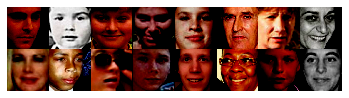

[0 0 0 1 1 0 1 1]


In [10]:
vis_dataloader = DataLoader(train_dataset,
                        shuffle=True,
                        num_workers=0,
                        batch_size=8)
dataiter = iter(vis_dataloader)

example_batch = next(dataiter)
concatenated = torch.cat((example_batch[1],example_batch[2]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[3].numpy())

# Defining Neural Network

In [18]:
# class SiameseNetwork(nn.Module):
#     def __init__(self):
#         super(SiameseNetwork, self).__init__()
#         self.cnn1 = nn.Sequential(
#             nn.ReflectionPad2d(1),
#             nn.Conv2d(1, 4, kernel_size=3),
#             nn.ReLU(inplace=True),
#             nn.BatchNorm2d(4),
            
#             nn.ReflectionPad2d(1),
#             nn.Conv2d(4, 8, kernel_size=3),
#             nn.ReLU(inplace=True),
#             nn.BatchNorm2d(8),

#             nn.ReflectionPad2d(1),
#             nn.Conv2d(8, 8, kernel_size=3),
#             nn.ReLU(inplace=True),
#             nn.BatchNorm2d(8),

#         )

#         self.fc1 = nn.Sequential(
#             nn.Linear(8*224*224, 1024),
#             nn.ReLU(inplace=True),

#             nn.Linear(1024, 1024),
#             nn.ReLU(inplace=True),
            
#             nn.Linear(1024, 512),
#             nn.ReLU(inplace=True),
            
#             nn.Linear(512, 512),
#             nn.ReLU(inplace=True),
            
#             nn.Linear(512, 50),
#             nn.ReLU(inplace=True),
            
#             nn.Linear(50, 25))
        
#         self.fc2 = nn.Sequential(
#             nn.Linear(25,2)
#         )
        
#     def forward_once(self, x):
#         output = self.cnn1(x)
#         output = output.view(output.size()[0], -1)
#         output = self.fc1(output)
#         return output

#     def forward(self, input1, input2):
#         output1 = self.forward_once(input1)
#         output2 = self.forward_once(input2)
        
#         euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        
#         output = self.fc2(output1-output2)
        
#         return output

# VGG Face Net

In [19]:
class Vgg_face_dag(nn.Module):

    def __init__(self):
        super(Vgg_face_dag, self).__init__()
        self.meta = {'mean': [129.186279296875, 104.76238250732422, 93.59396362304688],
                     'std': [1, 1, 1],
                     'imageSize': [224, 224, 3]}
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu1_1 = nn.ReLU(inplace=True)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu1_2 = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)

        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu2_1 = nn.ReLU(inplace=True)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu2_2 = nn.ReLU(inplace=True)
        self.pool2 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)

        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu3_1 = nn.ReLU(inplace=True)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu3_2 = nn.ReLU(inplace=True)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu3_3 = nn.ReLU(inplace=True)
        self.pool3 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)

        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu4_1 = nn.ReLU(inplace=True)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu4_2 = nn.ReLU(inplace=True)
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu4_3 = nn.ReLU(inplace=True)
        self.pool4 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)

        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu5_1 = nn.ReLU(inplace=True)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu5_2 = nn.ReLU(inplace=True)
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu5_3 = nn.ReLU(inplace=True)
        self.pool5 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
        
        self.fc6 = nn.Linear(in_features=25088, out_features=4096, bias=True)
        self.relu6 = nn.ReLU(inplace=True)
        self.dropout6 = nn.Dropout(p=0.5)
        self.fc7 = nn.Linear(in_features=4096, out_features=4096, bias=True)
        self.relu7 = nn.ReLU(inplace=True)
        self.dropout7 = nn.Dropout(p=0.5)
        self.fc8 = nn.Linear(in_features=4096, out_features=2622, bias=True)

    def forward_once(self, x0):
        x1 = self.conv1_1(x0)
        x2 = self.relu1_1(x1)
        x3 = self.conv1_2(x2)
        x4 = self.relu1_2(x3)
        x5 = self.pool1(x4)
        x6 = self.conv2_1(x5)
        x7 = self.relu2_1(x6)
        x8 = self.conv2_2(x7)
        x9 = self.relu2_2(x8)
        x10 = self.pool2(x9)
        x11 = self.conv3_1(x10)
        x12 = self.relu3_1(x11)
        x13 = self.conv3_2(x12)
        x14 = self.relu3_2(x13)
        x15 = self.conv3_3(x14)
        x16 = self.relu3_3(x15)
        x17 = self.pool3(x16)
        x18 = self.conv4_1(x17)
        x19 = self.relu4_1(x18)
        x20 = self.conv4_2(x19)
        x21 = self.relu4_2(x20)
        x22 = self.conv4_3(x21)
        x23 = self.relu4_3(x22)
        x24 = self.pool4(x23)
        x25 = self.conv5_1(x24)
        x26 = self.relu5_1(x25)
        x27 = self.conv5_2(x26)
        x28 = self.relu5_2(x27)
        x29 = self.conv5_3(x28)
        x30 = self.relu5_3(x29)
        x31_preflatten = self.pool5(x30)
        x31 = x31_preflatten.view(x31_preflatten.size(0), -1)
        x32 = self.fc6(x31)
        x33 = self.relu6(x32)
        x34 = self.dropout6(x33)
        x35 = self.fc7(x34)
        x36 = self.relu7(x35)
        x37 = self.dropout7(x36)
        x38 = self.fc8(x37)
        return x38
    
    def forward(self,input1,input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        
        #euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        difference = output1 - output2
        return difference

def vgg_face_dag(weights_path=None, **kwargs):
    """
    load imported model instance

    Args:
        weights_path (str): If set, loads model weights from the given path
    """
    model = Vgg_face_dag()
    if weights_path:
        state_dict = torch.load(weights_path)
        model.load_state_dict(state_dict)
    return model

In [20]:
vggnet = vgg_face_dag(weights_path="./pytorch-pretrained-models-for-face-detection/VGG Face")
vggnet = vggnet.cuda()
for param in vggnet.parameters(): 
    param.requires_grad = False

In [21]:
# if train_on_gpu:
#     net = SiameseNetwork().cuda()
# else:
#     net= SiameseNetwork()

# Classification Model

In [22]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Sequential(
            nn.Linear(2622, 1024),
            nn.ReLU(inplace=True),
            
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),

            nn.Linear(128, 2))
  
    def forward(self, x):
        x = self.fc1(x)
        return x

In [23]:
#model = Model().cuda()
#net = nn.Sequential(vgg_face_dag(weights_path="../input/pytorch-pretrained-models-for-face-detection/VGG Face").cuda(),Model().cuda())
net = Model().cuda()

# Optimizer

In [24]:
# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.008, momentum=0.9)

# Configuration Class

In [25]:
class Config():
    training_dir = "./recognizing-faces-in-the-wild/train/"
    testing_dir = "./recognizing-faces-in-the-wild/test/"
    batch_size = 64
    train_number_epochs = 150
    num_workers = 0

# Training and Validation Dataloader

In [26]:
# # percentage of training set to use as validation
# valid_size = 0.2

# # obtain training indices that will be used for validation
# num_train = len(train_dataset)
# indices = list(range(num_train))
# np.random.shuffle(indices)
# split = int(np.floor(valid_size * num_train))
# train_idx, valid_idx = indices[split:], indices[:split]

# # define samplers for obtaining training and validation batches
# train_sampler = SubsetRandomSampler(train_idx)
# valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(train_dataset,shuffle=True,num_workers=Config.num_workers, batch_size = Config.batch_size)
valid_loader = torch.utils.data.DataLoader(valid_dataset,shuffle=True,num_workers=Config.num_workers, batch_size = Config.batch_size)

In [27]:
print(len(valid_loader))

22


# Training the model

In [28]:
train_counter = []
train_loss_history = []
train_iteration_number= 0

valid_counter = []
valid_loss_history = []
valid_iteration_number= 0

# initialize tracker for minimum validation loss
valid_loss_min = np.Inf # set initial "min" to infinity

train_class_correct = list(0 for i in range(2))
train_class_total = list(0 for i in range(2))

valid_class_correct = list(0 for i in range(2))
valid_class_total = list(0 for i in range(2))

In [30]:
for i in train_loader:
    a=2

In [31]:
for epoch in range(0,Config.train_number_epochs):
    train_loss = 0.0
    valid_loss = 0.0
    net.train()
    for i, data in enumerate(train_loader,0):
        row, img0, img1 , label = data
        row, img0, img1 , label = row.cuda(), img0.cuda(), img1.cuda() , label.cuda()
        
        optimizer.zero_grad()
        output1= vggnet(img0,img1)
        output = net(output1)
        _, pred= torch.max(output,1)

        loss = criterion(output,label)
        loss.backward()
        
        optimizer.step()
        
        correct = pred.eq(label.view_as(pred))
        for j in range(len(label)):
                        target = label[j].data
                        train_class_correct[target] += correct[j].item()
                        train_class_total[target] += 1
                        
        if i%30 == 0:
            print("Epoch number {}\n Current loss {}\n".format(epoch+1,loss.item()))
            train_iteration_number +=30
            train_counter.append(train_iteration_number)
            train_loss_history.append(loss.item())

            for i in range(2):
                if train_class_total[i] > 0:
                        print('\nTraining Accuracy of %5s: %2d%% (%2d/%2d)' % (
                            str(i), 100 * train_class_correct[i] / train_class_total[i],
                            np.sum(train_class_correct[i]), np.sum(train_class_total[i])))

            print('\nTraining Accuracy (Overall): %2d%% (%2d/%2d)' % (
                100. * np.sum(train_class_correct) / np.sum(train_class_total),
                np.sum(train_class_correct), np.sum(train_class_total)))
    
    net.eval()
    for i, data in enumerate(valid_loader,0):
        row, img0, img1 , label = data
        row, img0, img1 , label = row.cuda(), img0.cuda(), img1.cuda() , label.cuda()
        
        output1= vggnet(img0,img1)
        output = net(output1)
        #combined = torch.cat([vgg,res1,sen1],1)
        #output= net(combined)
        _, pred= torch.max(output,1)

        loss = criterion(output,label)
        
        correct = pred.eq(label.view_as(pred))
        for j in range(len(label)):
                        target = label[j].data
                        valid_class_correct[target] += correct[j].item()
                        valid_class_total[target] += 1
        valid_loss += loss.item()                
        if i%30 == 0:
            print("Epoch number {}\n Current loss {}\n".format(epoch+1,loss.item()))
            valid_iteration_number +=30
            valid_counter.append(valid_iteration_number)
            valid_loss_history.append(loss.item())

            for i in range(2):
                if train_class_total[i] > 0:
                        print('\nValdiation Accuracy of %5s: %2d%% (%2d/%2d)' % (
                            str(i), 100 * valid_class_correct[i] / valid_class_total[i],
                            np.sum(valid_class_correct[i]), np.sum(valid_class_total[i])))

            print('\nValdiation Accuracy (Overall): %2d%% (%2d/%2d)' % (
                100. * np.sum(valid_class_correct) / np.sum(valid_class_total),
                np.sum(valid_class_correct), np.sum(valid_class_total)))
            
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(net.state_dict(), 'model.pt')
        valid_loss_min = valid_loss

Epoch number 1
 Current loss 0.6934438347816467


Training Accuracy of     0:  0% ( 0/32)

Training Accuracy of     1: 100% (32/32)

Training Accuracy (Overall): 50% (32/64)
Epoch number 1
 Current loss 0.6913734078407288


Training Accuracy of     0:  0% ( 0/935)

Training Accuracy of     1: 100% (1049/1049)

Training Accuracy (Overall): 52% (1049/1984)
Epoch number 1
 Current loss 0.6973947882652283


Training Accuracy of     0:  0% ( 0/1890)

Training Accuracy of     1: 100% (2014/2014)

Training Accuracy (Overall): 51% (2014/3904)
Epoch number 1
 Current loss 0.6853286623954773


Valdiation Accuracy of     0: 100% (43/43)

Valdiation Accuracy of     1:  0% ( 0/21)

Valdiation Accuracy (Overall): 67% (43/64)
Validation loss decreased (inf --> 15.204142).  Saving model ...
Epoch number 2
 Current loss 0.6955687999725342


Training Accuracy of     0: 14% (380/2680)

Training Accuracy of     1: 85% (2372/2762)

Training Accuracy (Overall): 50% (2752/5442)
Epoch number 2
 Current loss 0



Valdiation Accuracy of     0: 30% (2157/7134)

Valdiation Accuracy of     1: 69% (4458/6380)

Valdiation Accuracy (Overall): 48% (6615/13514)
Epoch number 12
 Current loss 0.6926040053367615


Training Accuracy of     0: 20% (5897/29193)

Training Accuracy of     1: 79% (23973/30029)

Training Accuracy (Overall): 50% (29870/59222)
Epoch number 12
 Current loss 0.6883589029312134


Training Accuracy of     0: 21% (6579/30100)

Training Accuracy of     1: 78% (24255/31042)

Training Accuracy (Overall): 50% (30834/61142)
Epoch number 12
 Current loss 0.6984958052635193


Training Accuracy of     0: 21% (6579/31071)

Training Accuracy of     1: 78% (25204/31991)

Training Accuracy (Overall): 50% (31783/63062)
Epoch number 12
 Current loss 0.6936173439025879


Valdiation Accuracy of     0: 34% (2724/7839)

Valdiation Accuracy of     1: 66% (4696/7020)

Valdiation Accuracy (Overall): 49% (7420/14859)
Epoch number 13
 Current loss 0.6910623908042908


Training Accuracy of     0: 22% (7140/3



Training Accuracy of     0: 26% (15209/56621)

Training Accuracy of     1: 76% (44319/58301)

Training Accuracy (Overall): 51% (59528/114922)
Epoch number 22
 Current loss 0.6776828169822693


Training Accuracy of     0: 27% (15732/57594)

Training Accuracy of     1: 75% (44960/59248)

Training Accuracy (Overall): 51% (60692/116842)
Epoch number 22
 Current loss 0.6920279264450073


Valdiation Accuracy of     0: 25% (3843/14950)

Valdiation Accuracy of     1: 77% (10318/13359)

Valdiation Accuracy (Overall): 50% (14161/28309)
Validation loss decreased (15.095529 --> 14.975462).  Saving model ...
Epoch number 23
 Current loss 0.6822826862335205


Training Accuracy of     0: 27% (16257/58356)

Training Accuracy of     1: 75% (45372/60024)

Training Accuracy (Overall): 52% (61629/118380)
Epoch number 23
 Current loss 0.6748501062393188


Training Accuracy of     0: 28% (16838/59299)

Training Accuracy of     1: 75% (46008/61001)

Training Accuracy (Overall): 52% (62846/120300)
Epoch num

Training Accuracy (Overall): 55% (93037/166782)
Epoch number 32
 Current loss 0.5780362486839294


Training Accuracy of     0: 37% (30952/83166)

Training Accuracy of     1: 74% (63354/85536)

Training Accuracy (Overall): 55% (94306/168702)
Epoch number 32
 Current loss 0.6463012099266052


Training Accuracy of     0: 37% (31489/84082)

Training Accuracy of     1: 74% (64127/86540)

Training Accuracy (Overall): 56% (95616/170622)
Epoch number 32
 Current loss 0.6209548115730286


Valdiation Accuracy of     0: 35% (7818/22041)

Valdiation Accuracy of     1: 75% (14965/19718)

Valdiation Accuracy (Overall): 54% (22783/41759)
Epoch number 33
 Current loss 0.5968099236488342


Training Accuracy of     0: 37% (31992/84860)

Training Accuracy of     1: 74% (64645/87300)

Training Accuracy (Overall): 56% (96637/172160)
Epoch number 33
 Current loss 0.5120522379875183


Training Accuracy of     0: 37% (32602/85827)

Training Accuracy of     1: 74% (65332/88253)

Training Accuracy (Overall): 56

Training Accuracy of     1: 74% (83698/112813)

Training Accuracy (Overall): 59% (131414/222482)
Epoch number 42
 Current loss 0.5446801781654358


Training Accuracy of     0: 43% (48362/110633)

Training Accuracy of     1: 74% (84437/113769)

Training Accuracy (Overall): 59% (132799/224402)
Epoch number 42
 Current loss 0.6566259860992432


Valdiation Accuracy of     0: 40% (11946/29141)

Valdiation Accuracy of     1: 76% (19884/26068)

Valdiation Accuracy (Overall): 57% (31830/55209)
Validation loss decreased (12.471070 --> 12.460274).  Saving model ...
Epoch number 43
 Current loss 0.5584642887115479


Training Accuracy of     0: 43% (48835/111372)

Training Accuracy of     1: 74% (85045/114568)

Training Accuracy (Overall): 59% (133880/225940)
Epoch number 43
 Current loss 0.5328956246376038


Training Accuracy of     0: 44% (49495/112342)

Training Accuracy of     1: 74% (85737/115518)

Training Accuracy (Overall): 59% (135232/227860)
Epoch number 43
 Current loss 0.54901188611984

Training Accuracy of     0: 47% (65783/137095)

Training Accuracy of     1: 74% (105553/141087)

Training Accuracy (Overall): 61% (171336/278182)
Epoch number 52
 Current loss 0.633308470249176


Valdiation Accuracy of     0: 46% (16697/36245)

Valdiation Accuracy of     1: 75% (24436/32414)

Valdiation Accuracy (Overall): 59% (41133/68659)
Epoch number 53
 Current loss 0.4919632077217102


Training Accuracy of     0: 48% (66331/137881)

Training Accuracy of     1: 74% (106126/141839)

Training Accuracy (Overall): 61% (172457/279720)
Epoch number 53
 Current loss 0.5720721483230591


Training Accuracy of     0: 48% (66975/138832)

Training Accuracy of     1: 74% (106906/142808)

Training Accuracy (Overall): 61% (173881/281640)
Epoch number 53
 Current loss 0.42064499855041504


Training Accuracy of     0: 48% (67603/139763)

Training Accuracy of     1: 74% (107676/143797)

Training Accuracy (Overall): 61% (175279/283560)
Epoch number 53
 Current loss 0.6926715970039368


Valdiation Acc

Valdiation Accuracy (Overall): 61% (50360/82109)
Epoch number 63
 Current loss 0.3681831657886505


Training Accuracy of     0: 51% (84272/164387)

Training Accuracy of     1: 75% (127609/169113)

Training Accuracy (Overall): 63% (211881/333500)
Epoch number 63
 Current loss 0.6857911944389343


Training Accuracy of     0: 51% (84927/165347)

Training Accuracy of     1: 75% (128366/170073)

Training Accuracy (Overall): 63% (213293/335420)
Epoch number 63
 Current loss 0.5044355392456055


Training Accuracy of     0: 51% (85562/166274)

Training Accuracy of     1: 75% (129135/171066)

Training Accuracy (Overall): 63% (214697/337340)
Epoch number 63
 Current loss 0.5579707026481628


Valdiation Accuracy of     0: 49% (21843/44055)

Valdiation Accuracy of     1: 74% (29430/39399)

Valdiation Accuracy (Overall): 61% (51273/83454)
Epoch number 64
 Current loss 0.4632830023765564


Training Accuracy of     0: 51% (86098/167045)

Training Accuracy of     1: 75% (129754/171833)

Training Accur

Training Accuracy (Overall): 65% (251936/387280)
Epoch number 73
 Current loss 0.43201810121536255


Training Accuracy of     0: 53% (103381/191872)

Training Accuracy of     1: 75% (149961/197328)

Training Accuracy (Overall): 65% (253342/389200)
Epoch number 73
 Current loss 0.48539048433303833


Training Accuracy of     0: 53% (104058/192825)

Training Accuracy of     1: 76% (150761/198295)

Training Accuracy (Overall): 65% (254819/391120)
Epoch number 73
 Current loss 0.4514947235584259


Valdiation Accuracy of     0: 51% (26488/51162)

Valdiation Accuracy of     1: 74% (33967/45742)

Valdiation Accuracy (Overall): 62% (60455/96904)
Epoch number 74
 Current loss 0.4970181882381439


Training Accuracy of     0: 54% (104562/193559)

Training Accuracy of     1: 76% (151425/199099)

Training Accuracy (Overall): 65% (255987/392658)
Epoch number 74
 Current loss 0.6163069605827332


Training Accuracy of     0: 54% (105208/194491)

Training Accuracy of     1: 76% (152210/200087)

Training



Training Accuracy of     0: 56% (123165/219327)

Training Accuracy of     1: 76% (172914/225573)

Training Accuracy (Overall): 66% (296079/444900)
Epoch number 83
 Current loss 0.7446815967559814


Valdiation Accuracy of     0: 53% (31367/58264)

Valdiation Accuracy of     1: 73% (38366/52090)

Valdiation Accuracy (Overall): 63% (69733/110354)
Epoch number 84
 Current loss 0.6020812392234802


Training Accuracy of     0: 56% (123675/220063)

Training Accuracy of     1: 76% (173569/226375)

Training Accuracy (Overall): 66% (297244/446438)
Epoch number 84
 Current loss 0.5046061873435974


Training Accuracy of     0: 56% (124294/220986)

Training Accuracy of     1: 76% (174391/227372)

Training Accuracy (Overall): 66% (298685/448358)
Epoch number 84
 Current loss 0.472525030374527


Training Accuracy of     0: 56% (124995/221942)

Training Accuracy of     1: 76% (175138/228336)

Training Accuracy (Overall): 66% (300133/450278)
Epoch number 84
 Current loss 0.5937938690185547


Valdiati

Valdiation Accuracy of     1: 73% (42879/58454)

Valdiation Accuracy (Overall): 63% (78921/123804)
Epoch number 94
 Current loss 0.42801594734191895


Training Accuracy of     0: 58% (143157/246574)

Training Accuracy of     1: 77% (195870/253644)

Training Accuracy (Overall): 67% (339027/500218)
Epoch number 94
 Current loss 0.4736159145832062


Training Accuracy of     0: 58% (143864/247509)

Training Accuracy of     1: 77% (196666/254629)

Training Accuracy (Overall): 67% (340530/502138)
Epoch number 94
 Current loss 0.4206913113594055


Training Accuracy of     0: 58% (144544/248446)

Training Accuracy of     1: 77% (197489/255612)

Training Accuracy (Overall): 67% (342033/504058)
Epoch number 94
 Current loss 0.7576950788497925


Valdiation Accuracy of     0: 55% (36565/66059)

Valdiation Accuracy of     1: 73% (43284/59090)

Valdiation Accuracy (Overall): 63% (79849/125149)
Epoch number 95
 Current loss 0.42377087473869324


Training Accuracy of     0: 58% (145133/249226)

Traini

Training Accuracy of     1: 77% (218254/280914)

Training Accuracy (Overall): 68% (381100/553998)
Epoch number 104
 Current loss 0.46199867129325867


Training Accuracy of     0: 59% (163540/274045)

Training Accuracy of     1: 77% (219037/281873)

Training Accuracy (Overall): 68% (382577/555918)
Epoch number 104
 Current loss 0.38286417722702026


Training Accuracy of     0: 59% (164233/274968)

Training Accuracy of     1: 77% (219868/282870)

Training Accuracy (Overall): 68% (384101/557838)
Epoch number 104
 Current loss 0.49538594484329224


Valdiation Accuracy of     0: 57% (41729/73162)

Valdiation Accuracy of     1: 72% (47288/65437)

Valdiation Accuracy (Overall): 64% (89017/138599)
Validation loss decreased (12.189140 --> 12.028862).  Saving model ...
Epoch number 105
 Current loss 0.3783152401447296


Training Accuracy of     0: 59% (164819/275741)

Training Accuracy of     1: 77% (220505/283635)

Training Accuracy (Overall): 68% (385324/559376)
Epoch number 105
 Current loss 

Training Accuracy of     0: 60% (183214/300532)

Training Accuracy of     1: 78% (241668/309166)

Training Accuracy (Overall): 69% (424882/609698)
Epoch number 114
 Current loss 0.509032130241394


Training Accuracy of     0: 61% (183944/301490)

Training Accuracy of     1: 78% (242491/310128)

Training Accuracy (Overall): 69% (426435/611618)
Epoch number 114
 Current loss 0.605816662311554


Valdiation Accuracy of     0: 57% (46327/80262)

Valdiation Accuracy of     1: 72% (51960/71787)

Valdiation Accuracy (Overall): 64% (98287/152049)
Epoch number 115
 Current loss 0.3709137439727783


Training Accuracy of     0: 61% (184511/302247)

Training Accuracy of     1: 78% (243143/310909)

Training Accuracy (Overall): 69% (427654/613156)
Epoch number 115
 Current loss 0.5162569880485535


Training Accuracy of     0: 61% (185196/303186)

Training Accuracy of     1: 78% (243971/311890)

Training Accuracy (Overall): 69% (429167/615076)
Epoch number 115
 Current loss 0.4246363937854767


Traini

Training Accuracy of     0: 62% (204169/327987)

Training Accuracy of     1: 78% (265248/337411)

Training Accuracy (Overall): 70% (469417/665398)
Epoch number 124
 Current loss 0.4450068175792694


Valdiation Accuracy of     0: 58% (51122/87361)

Valdiation Accuracy of     1: 72% (56362/78138)

Valdiation Accuracy (Overall): 64% (107484/165499)
Epoch number 125
 Current loss 0.4615982174873352


Training Accuracy of     0: 62% (204757/328753)

Training Accuracy of     1: 78% (265906/338183)

Training Accuracy (Overall): 70% (470663/666936)
Epoch number 125
 Current loss 0.37262240052223206


Training Accuracy of     0: 62% (205493/329713)

Training Accuracy of     1: 78% (266727/339143)

Training Accuracy (Overall): 70% (472220/668856)
Epoch number 125
 Current loss 0.43515580892562866


Training Accuracy of     0: 62% (206238/330676)

Training Accuracy of     1: 78% (267525/340100)

Training Accuracy (Overall): 70% (473763/670776)
Epoch number 125
 Current loss 0.7353270649909973


V

Valdiation Accuracy of     0: 58% (55597/94463)

Valdiation Accuracy of     1: 72% (61156/84486)

Valdiation Accuracy (Overall): 65% (116753/178949)
Epoch number 135
 Current loss 0.3452604413032532


Training Accuracy of     0: 63% (225259/355263)

Training Accuracy of     1: 79% (288933/365453)

Training Accuracy (Overall): 71% (514192/720716)
Epoch number 135
 Current loss 0.41266730427742004


Training Accuracy of     0: 63% (225982/356189)

Training Accuracy of     1: 79% (289785/366447)

Training Accuracy (Overall): 71% (515767/722636)
Epoch number 135
 Current loss 0.4201403558254242


Training Accuracy of     0: 63% (226745/357151)

Training Accuracy of     1: 79% (290603/367405)

Training Accuracy (Overall): 71% (517348/724556)
Epoch number 135
 Current loss 0.6847172379493713


Valdiation Accuracy of     0: 58% (55990/95170)

Valdiation Accuracy of     1: 72% (61692/85124)

Valdiation Accuracy (Overall): 65% (117682/180294)
Epoch number 136
 Current loss 0.5713587403297424




Training Accuracy of     0: 64% (246248/381769)

Training Accuracy of     1: 79% (312181/392727)

Training Accuracy (Overall): 72% (558429/774496)
Epoch number 145
 Current loss 0.45788663625717163


Training Accuracy of     0: 64% (246999/382720)

Training Accuracy of     1: 79% (312991/393696)

Training Accuracy (Overall): 72% (559990/776416)
Epoch number 145
 Current loss 0.5027171969413757


Training Accuracy of     0: 64% (247714/383668)

Training Accuracy of     1: 79% (313808/394668)

Training Accuracy (Overall): 72% (561522/778336)
Epoch number 145
 Current loss 0.6544631719589233


Valdiation Accuracy of     0: 59% (60669/102268)

Valdiation Accuracy of     1: 72% (66361/91476)

Valdiation Accuracy (Overall): 65% (127030/193744)
Epoch number 146
 Current loss 0.3617844879627228


Training Accuracy of     0: 64% (248311/384426)

Training Accuracy of     1: 79% (314469/395448)

Training Accuracy (Overall): 72% (562780/779874)
Epoch number 146
 Current loss 0.5346216559410095


T

# Training and Validation Loss


 Training Loss History


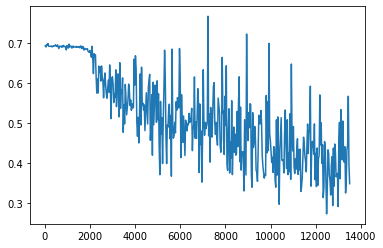


 Validation Loss History


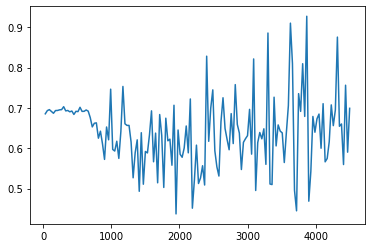

In [32]:
print('\n Training Loss History')
show_plot(train_counter,train_loss_history)

print('\n Validation Loss History')
show_plot(valid_counter,valid_loss_history)

# Loading Saved Model

In [ ]:
net.load_state_dict(torch.load('model.pt'))

Now that our model is trained, we'll see how the sample submissions are

In [ ]:
sample_submission = pd.read_csv("../input/recognizing-faces-in-the-wild/sample_submission.csv")
sample_submission.head()

In [ ]:
new = sample_submission["img_pair"].str.split("-", n = 1, expand = True)

# making separate first name column from new data frame 
sample_submission["Person1"]= new[0]
# making separate last name column from new data frame 
sample_submission["Person2"]= new[1]

# Dropping old Name columns
sample_submission.head()

# Custom Test Dataset


In [ ]:
class FamilyTestDataset(Dataset):
    """Family Dataset."""

    def __init__(self, df, root_dir, transform=None):
        """
        Args:
            df (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.relations = df
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.relations)
    
    def __getpair__(self,idx):
        pair = self.root_dir+self.relations.iloc[idx,2],\
        self.root_dir+self.relations.iloc[idx,3]
        return pair
    
    def __getlabel__(self,idx):
        return self.relations.iloc[idx,4]
    
    def __getitem__(self, idx):
        pair =  self.__getpair__(idx)
        
        img0 = Image.open(pair[0])
        img1 = Image.open(pair[1])
#         img0 = img0.convert("L")
#         img1 = img1.convert("L")
        
        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
            
        return idx,img0,img1

In [ ]:
transform = transforms.Compose([transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])])

test_dataset= FamilyTestDataset(df=sample_submission,root_dir="../input/recognizing-faces-in-the-wild/test/",transform=transform)

In [ ]:
test_loader = torch.utils.data.DataLoader(test_dataset,shuffle=True,num_workers=Config.num_workers, batch_size = Config.batch_size)

In [ ]:
net.eval()
for i, data in enumerate(test_loader,0):
    row, img0, img1 = data
    row, img0, img1 = row.cuda(), img0.cuda(), img1.cuda()
   
    output1= vggnet(img0,img1)
    output = net(output1)
    #output= net(img0,img1)
    _, pred= torch.max(output,1)
     
    count=0
    for item in row:
        sample_submission.loc[item,'is_related'] = pred[count].item()
        count+=1

In [ ]:
sample_submission.drop(columns =["Person1","Person2"], inplace = True)

In [ ]:
sample_submission['is_related'].value_counts()

In [ ]:
output= sample_submission.to_csv('output.csv',index=False)

In [ ]:
# import the modules we'll need
from IPython.display import HTML
import base64

# function that takes in a dataframe and creates a text link to  
# download it (will only work for files < 2MB or so)
def create_download_link(df, title = "Download CSV file", filename = "data.csv"):  
    
    csv = df.to_csv(index=False)
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

In [ ]:
create_download_link(sample_submission)